## **Forever Fading Sound**
*Or Basics of Filtering and Pre-processing*

- Almost every kind of audio processing is destructive.
- In a sense, audio engineering can be very subjective - we just fit sound to our psychoacoustic curves and other nonlinearities of our hearing. (Don't we do that with other information too?)
#
- To change a sound, something must be left behind.
- Phases get shifted, harmonics added or even parts of sound that were not there created.
- Filters - like almost everything else in audio - are simply controlled destruction.

**1. Pure-phase filter**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets
from IPython.display import display

C = 343.0  # speed of sound (m/s)

def comb_mag_db(f, tau, a=0.7):
    # Feedforward comb: H(f) = 1 + a*e^{-j2πfτ}
    mag = np.sqrt(1 + a*a + 2*a*np.cos(2*np.pi*f*tau))
    return 20*np.log10(np.maximum(mag, 1e-10))

def notch_freqs(tau, k_max=10):
    # For a>0 (same polarity), notches at (2k+1)/(2τ)
    k = np.arange(0, k_max)
    return (2*k + 1) / (2*tau)

def hz_formatter(x, pos):
    if x >= 1000:
        return f"{x/1000:.0f}k"
    return f"{int(x)}"

def plot_wall_comb(
    distance_to_wall_m=0.50,
    a=0.70,
    f_min=20,
    f_max=20000,
    n_points=6000,
    show_notches=30,
):
    # Round-trip path difference Δd = 2*d
    delta_d = 2.0 * distance_to_wall_m
    tau = delta_d / C  # seconds

    # LOG-spaced frequency grid (audio-style)
    f = np.logspace(np.log10(f_min), np.log10(f_max), n_points)
    mag_db = comb_mag_db(f, tau, a=a)

    df = 1.0 / tau
    notches = notch_freqs(tau, k_max=show_notches)
    notches_in_range = notches[(notches >= f_min) & (notches <= f_max)]

    plt.figure(figsize=(10.5, 4.5))
    plt.semilogx(f, mag_db)
    plt.ylim(-30, 6)
    plt.xlim(f_min, f_max)
    plt.grid(True, which="both", ls="--", alpha=0.35)

    # Audio ticks: 20 Hz → 20 kHz
    ticks = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
    plt.xticks(ticks)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(hz_formatter))

    # Mark notch lines (subtle)
    for nf in notches_in_range:
        plt.axvline(nf, alpha=0.10)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(
        f"Wall comb (dry + reflection): distance={distance_to_wall_m:.2f} m → τ={tau*1000:.2f} ms\n"
        f"Comb spacing Δf (spacing between teeth) ≈{df:.1f} Hz | reflection level a={a:.2f} | (Δd = 2·distance, round-trip)",
    )
    plt.show()

    if len(notches_in_range) > 0:
        txt = ", ".join(f"{x:.1f}" for x in notches_in_range[:10])
        print(f"First notches (Hz): {txt}")
    else:
        print("No notches in range for current settings.")

dist = widgets.FloatSlider(
    value=0.50, min=0.05, max=5.0, step=0.01,
    description="Wall/surface distance (one-way, m)", readout_format=".2f",
    style={"description_width": "300px"},
    layout=widgets.Layout(width="720px")
)
a = widgets.FloatSlider(
    value=0.70, min=0.0, max=0.99, step=0.01,
    description="Surface reflectivity (a)", readout_format=".2f",
    style={"description_width": "300px"},
    layout=widgets.Layout(width="720px")
)
ui = widgets.VBox(
    [dist, a],
    layout=widgets.Layout()
)
out = widgets.interactive_output(
    plot_wall_comb,
    {"distance_to_wall_m": dist, "a": a}
)
display(ui, out)



Output()

- Remember that comb filter we wher talking about in the previous lecture?
- That's not a pure phase filter (because sound loses energy over time), it's a phase-magnitude filter - it changes both phase and magnitude through self-interference.

Sidenote: magnitudes usually represent real acoustic levels, while amplitudes refer to recorded audio - but essentially it’s the same thing.

**The simplest pure-phase filter: a delay**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from scipy import signal

# ----------------------------
# Config
# ----------------------------
fs = 48000
dur_ms = 5000
t = np.arange(int(fs * dur_ms / 1000)) / fs

rng = np.random.default_rng(0)
x = rng.standard_normal(len(t)).astype(np.float32)

nperseg = 1024
noverlap = 768
window = "hann"
fmax_plot = 20000
zoom_ms = 200.0

# ----------------------------
# Helpers
# ----------------------------
def true_delay(sig, d_samps: int):
    sig = np.asarray(sig)
    if d_samps <= 0:
        return sig.copy()
    y = np.zeros_like(sig)
    if d_samps < len(sig):
        y[d_samps:] = sig[:-d_samps]
    return y

def stft_db(sig):
    f, tt, Z = signal.stft(
        sig, fs=fs, window=window,
        nperseg=nperseg, noverlap=noverlap,
        padded=False, boundary=None
    )
    mag = np.abs(Z)
    mag_db = 20 * np.log10(np.maximum(mag, 1e-12))
    return f, tt, mag_db

def nice_vlims(A_db, B_db, lo=5, hi=95, pad_db=3.0):
    vmin = min(np.percentile(A_db, lo), np.percentile(B_db, lo)) - pad_db
    vmax = max(np.percentile(A_db, hi), np.percentile(B_db, hi)) + pad_db
    return vmin, vmax

# ----------------------------
# Draw (NO Output(), NO clear_output)
# ----------------------------
def draw(delay_ms=0.0, mix=1.0):
    d = int(round(delay_ms * fs / 1000.0))

    y = true_delay(x, d)
    z_full = x + y
    z = (1 - mix) * x + mix * z_full

    f1, tt1, Xdb = stft_db(x)
    f2, tt2, Zdb = stft_db(z)
    vmin, vmax = nice_vlims(Xdb, Zdb)

    fmask1 = f1 <= min(fmax_plot, fs / 2)
    fmask2 = f2 <= min(fmax_plot, fs / 2)

    zoom_samps = int(round((zoom_ms / 1000.0) * fs))
    zoom_samps = max(256, min(len(x), zoom_samps))
    tz = (np.arange(zoom_samps) / fs) * 1000.0

    fig, axes = plt.subplots(
        2, 2, figsize=(13, 7),
        gridspec_kw={"height_ratios": [1.0, 1.15]},
        constrained_layout=True
    )

    axes[0, 0].plot(tz, x[:zoom_samps], lw=1.0, label="Original x")
    axes[0, 0].plot(tz, y[:zoom_samps], lw=1.0, label=f"Delayed y (d={d} samp)")
    axes[0, 0].set_title(f"Pure delay: {delay_ms:.3f} ms")
    axes[0, 0].set_xlabel("Time (ms)")
    axes[0, 0].set_ylabel("Amplitude")
    axes[0, 0].grid(alpha=0.25)
    axes[0, 0].legend(loc="upper right")

    axes[0, 1].plot(tz, z[:zoom_samps], lw=1.0)
    axes[0, 1].set_title(f"Sum → comb filtering (mix={mix:.2f})")
    axes[0, 1].set_xlabel("Time (ms)")
    axes[0, 1].grid(alpha=0.25)

    im0 = axes[1, 0].pcolormesh(
        tt1, f1[fmask1], Xdb[fmask1, :],
        shading="gouraud", cmap="inferno",
        vmin=vmin, vmax=vmax
    )
    axes[1, 0].set_title("Spectrogram: Original (white noise)")
    axes[1, 0].set_xlabel("Time (s)")
    axes[1, 0].set_ylabel("Frequency (Hz)")
    axes[1, 0].set_ylim(0, f1[fmask1][-1])

    im1 = axes[1, 1].pcolormesh(
        tt2, f2[fmask2], Zdb[fmask2, :],
        shading="gouraud", cmap="inferno",
        vmin=vmin, vmax=vmax
    )
    axes[1, 1].set_title("Spectrogram: Sum (comb notches)")
    axes[1, 1].set_xlabel("Time (s)")
    axes[1, 1].set_ylabel("Frequency (Hz)")
    axes[1, 1].set_ylim(0, f2[fmask2][-1])

    cbar = fig.colorbar(im1, ax=[axes[1, 0], axes[1, 1]], shrink=0.95)
    cbar.set_label("dB")

    if d > 0:
        spacing_hz = fs / d
        axes[0, 1].text(
            0.02, 0.95,
            f"Expected comb spacing ≈ {spacing_hz:.1f} Hz",
            transform=axes[0, 1].transAxes,
            va="top"
        )

    plt.show()
    # plt.close(fig)

# ----------------------------
# Widgets (single output path)
# ----------------------------
delay_knob = widgets.FloatLogSlider(
    value=1.0,
    base=10,
    min=np.log10(0.05),
    max=np.log10(30.0),
    step=0.01,
    description="Delay (ms, log)",
    continuous_update=True,
    readout_format=".3f",
    layout=widgets.Layout(width="50%"),
    style={"description_width": "160px"},
)

mix_knob = widgets.FloatSlider(
    value=1.0, min=0.0, max=1.0, step=0.05,
    description="Mix (Dry-Wet)",
    continuous_update=False,
    layout=widgets.Layout(width="50%"),
    style={"description_width": "160px"},
)

out = widgets.interactive_output(draw, {"delay_ms": delay_knob, "mix": mix_knob})
out.layout = widgets.Layout(min_height="620px")
display(widgets.VBox([delay_knob, mix_knob, out]))

- Now it’s a pure-phase filter - the sound doesn’t fade anymore.
- A pure delay alone is a pure-phase filter.
- The moment you mix it with the original signal, it becomes a comb filter - a phase–magnitude filter created by self-interference.
- Mix is simply how much delayed audio you add: Wet means more (high percentage), Dry means less (low percentage).
# 
- **Tiny delays matter far more than large ones.** Below 1 ms everything changes violently - above 10 ms it barely moves - that's why delay knob is logarithmic.
# 
- From here on, every filter (or EQ) you meet is just a more controlled version of this.
# 
- That's exactly why there's a golden rule of thumb in audio engineering called 3-to-1 (when we're not talking about defined stereo pairs with predefined distances and angles).
- The distance between microphones should be at least three times greater than their distance to the shared source - to decorrelate phase relationships.

Sidenote: phase is how active noise cancellation works in headphones, they just play inverted sound from a microphone on the outside, causing destructive interference and a perceived sense of empty space.


**2. Min-phase filters** (what audio engineers really love)
- Minimum-phase filters were created to minimize phase shifts during filtering.
- For a given magnitude response, the phase shift is as small as physically possible - all energy occurs as early as possible in time (no pre-ringing, only post-ringing).
- Minimum-phase filters preserve amplitudes, but can rotate phase heavily (steeper filters → more phase rotation).
#
- A straight phase line means constant delay.
- Curved phase means different frequencies are delayed by different amounts.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from scipy import signal

# ----------------------------
# Config
# ----------------------------
fs = 48000
fmin_plot = 20
fmax_plot = 20000
worN = 8192

HZ_TICKS  = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
HZ_LABELS = ["20", "50", "100", "200", "500", "1k", "2k", "5k", "10k", "20k"]

# White noise for spectrogram
dur_s = 2.0
rng = np.random.default_rng(0)
x = rng.standard_normal(int(fs * dur_s)).astype(np.float32)

# STFT params
nperseg = 1024
noverlap = 768
window = "hann"

# Impulse response view (ms)
pre_ms = 5.0
post_ms = 25.0

# ----------------------------
# Helpers
# ----------------------------
def design_band_sos(family, order, low_cut_hz, high_cut_hz, notch=False):
    btype = "bandstop" if notch else "bandpass"
    Wn = [float(low_cut_hz), float(high_cut_hz)]
    N = int(order)

    # fixed, sensible defaults
    rp = 1.0    # dB - gain in the passband can vary up to ±1 dB
    rs = 60.0   # dB - stopband must attenuate the signal by at least 60 dB

    if family == "Butterworth":
        return signal.butter(N, Wn, btype=btype, fs=fs, output="sos")
    elif family == "Chebyshev I":
        return signal.cheby1(N, rp, Wn, btype=btype, fs=fs, output="sos")
    elif family == "Chebyshev II":
        return signal.cheby2(N, rs, Wn, btype=btype, fs=fs, output="sos")
    elif family == "Elliptic":
        return signal.ellip(N, rp, rs, Wn, btype=btype, fs=fs, output="sos")
    else:
        raise ValueError(f"Unknown family: {family}")

def freq_response(sos):
    f, h = signal.sosfreqz(sos, worN=worN, fs=fs)
    amp = np.abs(h)
    phase_deg = np.degrees(np.unwrap(np.angle(h)))
    return f, amp, phase_deg

def stft_db(sig):
    f, tt, Z = signal.stft(
        sig, fs=fs, window=window,
        nperseg=nperseg, noverlap=noverlap,
        padded=False, boundary=None
    )
    mag = np.abs(Z)
    mag_db = 20 * np.log10(np.maximum(mag, 1e-12))
    return f, tt, mag_db

def impulse_response(sos, n_samps):
    imp = np.zeros(n_samps, dtype=np.float32)
    imp[0] = 1.0
    return signal.sosfilt(sos, imp)

# ----------------------------
# Draw
# ----------------------------
def draw(low_cut=80.0, high_cut=12000.0, order=4, notch=False, family="Butterworth"):
    low_cut_hz = float(low_cut)
    high_cut_hz = float(high_cut)
    order = int(order)

    sos = design_band_sos(family, order, low_cut_hz, high_cut_hz, notch=notch)

    # Frequency response
    f, amp, phase_deg = freq_response(sos)
    fmask = (f >= fmin_plot) & (f <= fmax_plot)

    # Spectrogram
    y = signal.sosfilt(sos, x)
    fspec, tspec, Ydb = stft_db(y)
    fmask_s = (fspec >= 0) & (fspec <= fmax_plot)
    vmin = np.percentile(Ydb, 5) - 3.0
    vmax = np.percentile(Ydb, 95) + 3.0

    # Impulse response
    pre_samps = int(round(pre_ms * fs / 1000.0))
    post_samps = int(round(post_ms * fs / 1000.0))
    n_ir = post_samps + 1
    h = impulse_response(sos, n_ir)

    t_neg = (np.arange(-pre_samps, 0) / fs) * 1000.0
    t_pos = (np.arange(0, n_ir) / fs) * 1000.0
    t_ir = np.concatenate([t_neg, t_pos])
    h_plot = np.concatenate([np.zeros(pre_samps), h])

    fig, axes = plt.subplots(
        2, 2, figsize=(13, 8),
        gridspec_kw={"height_ratios": [1.0, 1.15]},
        constrained_layout=True
    )

    mode_title = "Notch" if notch else "Bandpass"

    # Amplitude
    ax = axes[0, 0]
    ax.semilogx(f[fmask], amp[fmask])
    ax.set_xlim(fmin_plot, fmax_plot)
    ax.set_ylim(0, 1.1)
    ax.set_xticks(HZ_TICKS); ax.set_xticklabels(HZ_LABELS)
    ax.grid(True, which="both", alpha=0.25)
    ax.set_title(f"Amplitude • {family} • {mode_title}")
    ax.axvline(low_cut_hz); ax.axvline(high_cut_hz)

    # Phase
    ax = axes[0, 1]
    ax.semilogx(f[fmask], phase_deg[fmask])
    ax.set_xlim(fmin_plot, fmax_plot)
    ax.set_xticks(HZ_TICKS); ax.set_xticklabels(HZ_LABELS)
    ax.grid(True, which="both", alpha=0.25)
    ax.set_title("Phase (deg, unwrapped)")
    ax.axvline(low_cut_hz); ax.axvline(high_cut_hz)

    # Spectrogram
    ax = axes[1, 0]
    im = ax.pcolormesh(tspec, fspec[fmask_s], Ydb[fmask_s, :],
                       shading="gouraud", cmap="inferno",
                       vmin=vmin, vmax=vmax)
    ax.set_ylim(0, fmax_plot)
    ax.set_title("Spectrogram")
    fig.colorbar(im, ax=ax, shrink=0.9)

    # Impulse
    ax = axes[1, 1]
    ax.plot(t_ir, h_plot)
    ax.axvline(0)
    ax.grid(alpha=0.25)
    ax.set_xlim(-pre_ms, post_ms)
    ax.set_title("Impulse response (pre/post)")

    fig.suptitle(
        f"{family} {mode_title} • order={order} • low={low_cut_hz:.0f} Hz • high={high_cut_hz:.0f} Hz",
        y=1.02
    )

    plt.show()
    # plt.close(fig)

# ----------------------------
# Widgets
# ----------------------------
low_knob = widgets.IntSlider(value=80, min=20, max=500, step=1, description="Low (Hz)")
high_knob = widgets.IntSlider(value=12000, min=5000, max=20000, step=10, description="High (Hz)")
order_knob = widgets.IntSlider(value=4, min=1, max=12, step=1, description="Order")

family_dd = widgets.Dropdown(
    options=["Butterworth", "Chebyshev I", "Chebyshev II", "Elliptic"],
    value="Butterworth",
    description="Family"
)

notch_toggle = widgets.ToggleButton(value=False, description="Notch")

out = widgets.interactive_output(
    draw,
    {"low_cut": low_knob, "high_cut": high_knob, "order": order_knob,
     "notch": notch_toggle, "family": family_dd}
)

out.layout = widgets.Layout(min_height="820px")

display(widgets.VBox([family_dd, notch_toggle, low_knob, high_knob, order_knob, out]))

- Here's a bandpass filter - you can flip it into a bandstop (notch) with the Notch button. In notch mode, it cuts the selected frequency band, not everything else around it.
- Band-pass = keep the band. Notch = remove the band.

1. Amplitude response - what gets through / what gets cut.
2. Phase response - how much each frequency is 'rotated' (delayed in a frequency-dependent way).
3. Spectrogram of filtered white noise - a time-frequency picture of energy.
4. Impulse response (time-domain) - how the filter responds to an instant click.
#
- Order is how many stages the filter has. Higher order gives steeper cutoffs - but also more phase distortion and longer ringing.
#
- As you can see, the beautiful Butterworth filter needs a lot of order (many 'cycles' / sections) to really remove something. It's very smooth - but that smoothness costs steepness.
- Other filter families can achieve much sharper cutoffs with fewer orders - but you always pay a price: ripple (waviness in the frequency response), more phase distortion, and longer ringing in the time domain.
#
- Butterworth is gentle and clean, but inefficient.
- Chebyshev and Elliptic are aggressive and efficient - but they introduce ripple and time-domain artifacts.
# 
Sidenote: a gentle low-cut (high-pass) on voices or vocals is often useful to remove rumble and mic handling noise. 
- Look at the spectrogram to spot problem areas down low, or
- Simply move the cutoff higher until you hear it affecting the voice - then pull it back by ~20% to make sure you're not removing anything crucial.

**Pre-ring and Post-ring**
- When we process audio (including with filters), we sometimes add bits that wasn't there originally.
- If we feed the system a perfect impulse (a click), we can see exactly what gets added.
- An impulse contains everything and nothing at once - so whatever appears around is created by the processing itself.

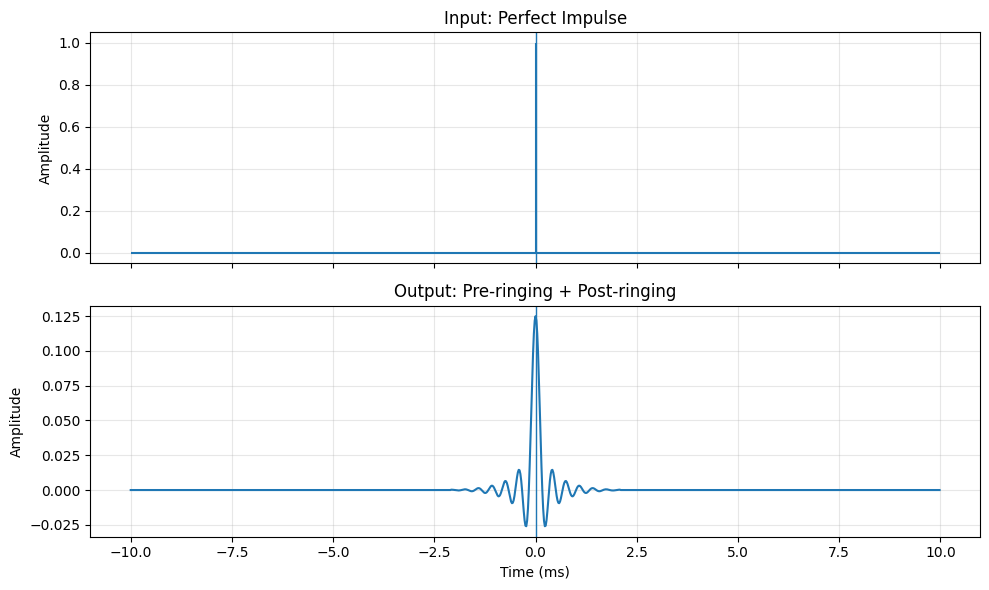

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

fs = 48000

# Time axis ±10 ms
t = np.arange(-0.01, 0.01, 1/fs)

# Linear-phase FIR lowpass (causes pre + post ringing)
numtaps = 201
fir = signal.firwin(numtaps, cutoff=3000, fs=fs)

# Put FIR taps into the same ±10 ms window, centered at 0 ms
h = np.zeros_like(t)
mid = len(t) // 2
L = len(fir)
start = mid - L // 2
h[start:start + L] = fir

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ---- Top: perfect impulse (as a centered vertical line) ----
axs[0].hlines(0, t[0]*1000, t[-1]*1000)   # baseline
axs[0].vlines(0, 0, 1)                    # the impulse at exactly 0 ms
axs[0].axvline(0, linewidth=1)
axs[0].grid(alpha=0.3)
axs[0].set_ylim(-0.05, 1.05)
axs[0].set_title("Input: Perfect Impulse")
axs[0].set_ylabel("Amplitude")

# ---- Bottom: filtered impulse (FIR impulse response) ----
axs[1].plot(t * 1000, h)
axs[1].axvline(0, linewidth=1)
axs[1].grid(alpha=0.3)
axs[1].set_title("Output: Pre-ringing + Post-ringing")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

- Psychoacoustically, pre-ringing matters much more.
- It muddies the initial transient - the very moment our ears use to localize and identify sounds - while post-ringing is perceived mostly as a natural extension of the tail.
- This is especially noticeable on sharp sounds like clicks and drums.

Sidenote: that’s why clipping sounds so bad. When a signal clips, it creates a sudden discontinuity - the waveform jumps instantly. Real physical systems (like a driver or diaphragm) can't change infinitely fast; they need time to move. That impossible jump turns into high-frequency energy and ringing, which we perceive as harsh clicks.

**3. Linear phase filters**
- Linear-phase filters keep all frequencies aligned in phase, but they achieve this by spreading energy symmetrically in time.
- They preserve relative timing between frequencies - but smear absolute timing of events.
- Linear phase can be created offline by filtering the sound, reversing it in time, filtering again, and reversing it back - letting phase cancel itself.
- Real-time linear-phase filtering doesn’t reverse audio - it delays the signal so all frequencies are shifted equally.
# 
- Minimum-phase bends frequency timing. Linear-phase smears transients.
- Linear-phase filters are used when phase relationships between microphones or signals are critical and must be preserved - no matter the cost.
- They avoid introducing relative delay between frequency components, which is essential for things like multi-mic recordings, parallel processing, or stereo coherence.
- Linear-phase preserves relationships. Minimum-phase preserves attacks.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from scipy import signal

# ----------------------------
# Config
# ----------------------------
fs = 48000
fmin_plot = 20
fmax_plot = 20000
worN = 8192

HZ_TICKS  = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
HZ_LABELS = ["20", "50", "100", "200", "500", "1k", "2k", "5k", "10k", "20k"]

# White noise for spectrogram
dur_s = 2.0
rng = np.random.default_rng(0)
x = rng.standard_normal(int(fs * dur_s)).astype(np.float32)

# STFT params
nperseg = 1024
noverlap = 768
window = "hann"

# Impulse response view (ms)
pre_ms = 5.0
post_ms = 25.0

# ----------------------------
# Helpers
# ----------------------------
def _odd(n: int) -> int:
    n = int(n)
    return n if (n % 2 == 1) else (n + 1)

def design_band_fir_linear(family, taps, low_cut_hz, high_cut_hz, notch=False):
    """
    Linear-phase FIR bandpass/bandstop.
    Returns FIR taps b (symmetric -> linear phase).
    """
    taps = _odd(taps)

    low = float(low_cut_hz)
    high = float(high_cut_hz)
    nyq = fs / 2.0
    low = np.clip(low, 1.0, nyq - 1.0)
    high = np.clip(high, low + 1.0, nyq - 1.0)

    pass_zero = True if notch else False  # firwin: bandstop if True, bandpass if False (when cutoff=[low, high])

    if family == "Hann":
        win = "hann"
    elif family == "Hamming":
        win = "hamming"
    elif family == "Blackman":
        win = "blackman"
    elif family == "Kaiser":
        win = ("kaiser", 8.0)
    else:
        raise ValueError(f"Unknown family: {family}")

    b = signal.firwin(taps, [low, high], pass_zero=pass_zero, window=win, fs=fs)
    return b

def freq_response_fir(b):
    f, h = signal.freqz(b, worN=worN, fs=fs)
    amp = np.abs(h)

    # PASSBAND mask (relative): keep only where magnitude is close to max
    amp_db = 20*np.log10(np.maximum(amp, 1e-12))
    good = amp_db > (np.max(amp_db) - 20)   # within 20 dB of peak (tweak: 10..40)

    delay = (len(b) - 1) / 2.0

    # remove linear delay in complex domain, then wrap phase to [-180, 180]
    h_resid = h * np.exp(1j * 2*np.pi * f * delay / fs)

    phase = np.full_like(amp, np.nan, dtype=float)
    phase[good] = np.degrees(np.angle(h_resid[good]))

    return f, amp, phase

def stft_db(sig):
    f, tt, Z = signal.stft(
        sig, fs=fs, window=window,
        nperseg=nperseg, noverlap=noverlap,
        padded=False, boundary=None
    )
    mag = np.abs(Z)
    mag_db = 20 * np.log10(np.maximum(mag, 1e-12))
    return f, tt, mag_db

def impulse_response_fir(b, n_samps):
    imp = np.zeros(n_samps, dtype=np.float32)
    imp[0] = 1.0
    return signal.lfilter(b, [1.0], imp)

# ----------------------------
# Draw
# ----------------------------
def draw(low_cut=80.0, high_cut=12000.0, taps=401, notch=False, family="Hann"):
    low_cut_hz = float(low_cut)
    high_cut_hz = float(high_cut)
    taps = int(taps)

    b = design_band_fir_linear(family, taps, low_cut_hz, high_cut_hz, notch=notch)
    taps_used = len(b)

    # Frequency response
    f, amp, phase_deg = freq_response_fir(b)
    fmask = (f >= fmin_plot) & (f <= fmax_plot)

    # Spectrogram
    y = signal.lfilter(b, [1.0], x)
    fspec, tspec, Ydb = stft_db(y)
    fmask_s = (fspec >= 0) & (fspec <= fmax_plot)
    vmin = np.percentile(Ydb, 5) - 3.0
    vmax = np.percentile(Ydb, 95) + 3.0

    # Impulse response
    pre_samps = int(round(pre_ms * fs / 1000.0))
    post_samps = int(round(post_ms * fs / 1000.0))
    n_ir = post_samps + 1
    h = impulse_response_fir(b, n_ir)

    t_neg = (np.arange(-pre_samps, 0) / fs) * 1000.0
    t_pos = (np.arange(0, n_ir) / fs) * 1000.0
    t_ir = np.concatenate([t_neg, t_pos])
    h_plot = np.concatenate([np.zeros(pre_samps), h])

    fig, axes = plt.subplots(
        2, 2, figsize=(13, 8),
        gridspec_kw={"height_ratios": [1.0, 1.15]},
        constrained_layout=True
    )

    mode_title = "Notch" if notch else "Bandpass"

    # Amplitude
    ax = axes[0, 0]
    ax.semilogx(f[fmask], amp[fmask])
    ax.set_xlim(fmin_plot, fmax_plot)
    ax.set_ylim(0, 1.1)
    ax.set_xticks(HZ_TICKS); ax.set_xticklabels(HZ_LABELS)
    ax.grid(True, which="both", alpha=0.25)
    ax.set_title(f"Amplitude • Linear-phase FIR • {family} • {mode_title}")
    ax.axvline(low_cut_hz); ax.axvline(high_cut_hz)

    # Phase
    ax = axes[0, 1]
    ax.semilogx(f[fmask], phase_deg[fmask])
    ax.set_xlim(fmin_plot, fmax_plot)
    ax.set_xticks(HZ_TICKS); ax.set_xticklabels(HZ_LABELS)
    ax.grid(True, which="both", alpha=0.25)
    ax.set_title("Phase deviation (deg)")
    ax.axvline(low_cut_hz); ax.axvline(high_cut_hz)

    # Spectrogram
    ax = axes[1, 0]
    im = ax.pcolormesh(tspec, fspec[fmask_s], Ydb[fmask_s, :],
                       shading="gouraud", cmap="inferno",
                       vmin=vmin, vmax=vmax)
    ax.set_ylim(0, fmax_plot)
    ax.set_title("Spectrogram")
    fig.colorbar(im, ax=ax, shrink=0.9)

    # Impulse
    ax = axes[1, 1]
    ax.plot(t_ir, h_plot)
    ax.axvline(0)
    ax.grid(alpha=0.25)
    ax.set_xlim(-pre_ms, post_ms)
    ax.set_title("Impulse response")

    fig.suptitle(
        f"{family} {mode_title} • taps={taps_used} • low={low_cut_hz:.0f} Hz • high={high_cut_hz:.0f} Hz",
        y=1.02
    )

    plt.show()

# ----------------------------
# Widgets
# ----------------------------
low_knob = widgets.IntSlider(value=80, min=20, max=500, step=1, description="Low (Hz)")
high_knob = widgets.IntSlider(value=12000, min=5000, max=20000, step=10, description="High (Hz)")

taps_knob = widgets.IntSlider(value=401, min=31, max=2001, step=2, description="Taps")

family_dd = widgets.Dropdown(
    options=["Hann", "Hamming", "Blackman", "Kaiser"],
    value="Hann",
    description="Window"
)

notch_toggle = widgets.ToggleButton(value=False, description="Notch")

out = widgets.interactive_output(
    draw,
    {"low_cut": low_knob, "high_cut": high_knob, "taps": taps_knob,
     "notch": notch_toggle, "family": family_dd}
)

out.layout = widgets.Layout(min_height="820px")
display(widgets.VBox([family_dd, notch_toggle, low_knob, high_knob, taps_knob, out]))

- Taps are the length of the FIR filter: more taps give sharper frequency response but add latency and pre-ringing.
- Linear-phase FIR (finite impulse responce) filters typically require significantly more computation than minimum-phase IIR (infinite impulse responce, feedback) filters for the same amplitude response.
- Linear-phase FIR filters become exponentially more expensive as frequency goes down.
- The lower the cutoff frequency, the more taps you need.
- The remaining phase deviation you see is just floating-point error.


**Equalizer or EQ**
#
- EQ is just what happens when we stack many filters together.
- It is simply a collection of filters connected in series.

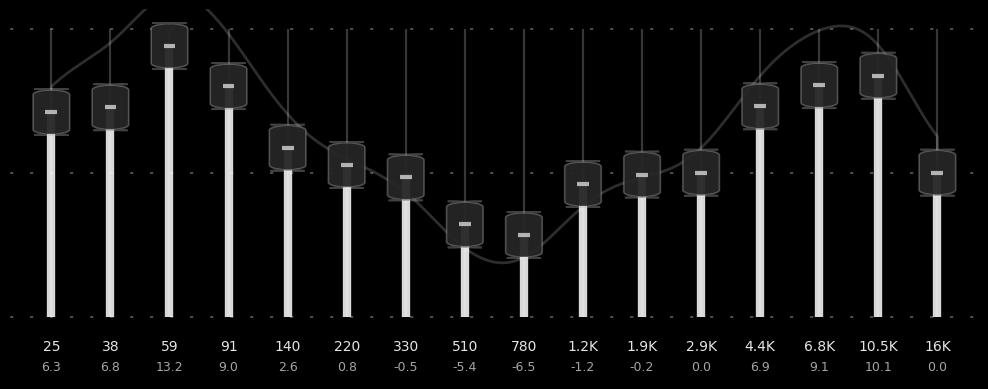

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

class GraphicEQDraggable:
    def __init__(
        self,
        freqs=(25, 38, 59, 91, 140, 220, 330, 510, 780, 1200, 1900, 2900, 4400, 6800, 10500, 16000),
        gains_db=(6.3, 6.8, 13.2, 9.0, 2.6, 0.8, -0.5, -5.4, -6.5, -1.2, -0.2, 0.0, 6.9, 9.1, 10.1, 0.0),
        db_range=15,
        bandwidth_oct=1.0,
        figsize=(12.5, 4.8),
    ):
        self.freqs = np.asarray(freqs, float)
        self.gains = np.clip(np.asarray(gains_db, float), -db_range, db_range)
        self.db_range = float(db_range)
        self.bandwidth_oct = float(bandwidth_oct)

        self.n = len(self.freqs)
        self.x = np.arange(self.n)

        self.y_min, self.y_max = -self.db_range, self.db_range

        # How wide a "column" counts as clicking that fader
        self.column_half_width = 0.45

        # Knob geometry (in data coords: x=band index, y=dB)
        self.knob_w = 0.32
        self.knob_h = 4.5

        self.active_i = None  # currently dragged band index

        self.fig, self.ax = plt.subplots(figsize=figsize)
        self.ax.set_facecolor("black")
        self.fig.patch.set_facecolor("black")

        self._draw_static()
        self._build_artists()
        self._connect()
        self._redraw_all()

    def fmt_freq(self, fr):
        if fr >= 1000:
            return f"{fr/1000:.1f}K".replace(".0K", "K")
        return f"{int(fr)}"

    def _draw_static(self):
        # Dotted guide lines
        for y in (self.y_min, 0, self.y_max):
            self.ax.hlines(
                y, -0.7, self.n - 0.3,
                colors="white", linestyles=(0, (2, 10)),
                linewidth=1.2, alpha=0.35, zorder=0
            )

        # Track lines
        for i in range(self.n):
            self.ax.vlines(i, self.y_min, self.y_max, color="white", lw=1.6, alpha=0.22, zorder=1)

        # Labels
        self.gain_texts = []
        for i, fr in enumerate(self.freqs):
            self.ax.text(i, self.y_min - 2.4, self.fmt_freq(fr),
                         color="white", ha="center", va="top", fontsize=10, alpha=0.9)
            t = self.ax.text(i, self.y_min - 4.6, "",
                             color="white", ha="center", va="top", fontsize=9, alpha=0.65)
            self.gain_texts.append(t)

        # Frame cosmetics
        self.ax.set_xlim(-0.7, self.n - 0.3)
        self.ax.set_ylim(self.y_min - 6.5, self.y_max + 2.0)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        for s in self.ax.spines.values():
            s.set_visible(False)

    def _build_artists(self):
        # Filled bars
        self.fill_lines = []
        for i in range(self.n):
            ln = self.ax.vlines(i, self.y_min, self.gains[i], color="white", lw=6.0, alpha=0.85, zorder=2)
            self.fill_lines.append(ln)

        # Knobs + highlight lines
        self.knobs = []
        self.knob_hl = []
        for i in range(self.n):
            g = self.gains[i]
            knob = FancyBboxPatch(
                (i - self.knob_w/2, g - self.knob_h/2),
                self.knob_w, self.knob_h,
                boxstyle="round,pad=0.15,rounding_size=0.6",
                linewidth=1.2,
                edgecolor=(1, 1, 1, 0.25),
                facecolor=(0.15, 0.15, 0.15, 0.95),
                zorder=4
            )
            self.ax.add_patch(knob)
            self.knobs.append(knob)

            hl = self.ax.hlines(g, i - 0.10, i + 0.10, colors="white", lw=3, alpha=0.65, zorder=5)
            self.knob_hl.append(hl)

        # Overlap/sum curve (background)
        self.sum_line, = self.ax.plot([], [], color="white", lw=2.0, alpha=0.18, zorder=1.5)

    def _connect(self):
        self.fig.canvas.mpl_connect("button_press_event", self._on_press)
        self.fig.canvas.mpl_connect("button_release_event", self._on_release)
        self.fig.canvas.mpl_connect("motion_notify_event", self._on_motion)

    def _band_from_x(self, xdata):
        """Map mouse x position to nearest band index if close enough."""
        if xdata is None:
            return None
        i = int(np.round(xdata))
        if i < 0 or i >= self.n:
            return None
        if abs(xdata - i) <= self.column_half_width:
            return i
        return None

    def _on_press(self, event):
        if event.button != 1:
            return
        if event.inaxes != self.ax:
            return
        i = self._band_from_x(event.xdata)
        if i is None or event.ydata is None:
            return

        # Click anywhere in the column => jump knob to that y immediately
        self.active_i = i
        self._set_gain(i, event.ydata)

    def _on_release(self, event):
        self.active_i = None

    def _on_motion(self, event):
        if self.active_i is None:
            return
        if event.inaxes != self.ax or event.ydata is None:
            return
        self._set_gain(self.active_i, event.ydata)

    def _set_gain(self, i, ydata):
        g = float(np.clip(ydata, self.y_min, self.y_max))
        self.gains[i] = g
        self._update_band(i)
        self._update_sum_curve()
        self.fig.canvas.draw_idle()

    def _update_band(self, i):
        g = self.gains[i]
        self.fill_lines[i].set_segments([[[i, self.y_min], [i, g]]])
        self.knobs[i].set_bounds(i - self.knob_w/2, g - self.knob_h/2, self.knob_w, self.knob_h)
        self.knob_hl[i].set_segments([[[i - 0.10, g], [i + 0.10, g]]])
        self.gain_texts[i].set_text(f"{g:+.1f}".replace("+", ""))

    def _update_sum_curve(self):
        f_plot = np.logspace(np.log10(20), np.log10(20000), 2500)
        xf = np.log2(f_plot)
        x0 = np.log2(self.freqs)
        sigma = self.bandwidth_oct / 2.355  # FWHM ≈ 2.355*sigma

        W = np.exp(-0.5 * ((xf[:, None] - x0[None, :]) / sigma) ** 2)
        total_db = (W * self.gains[None, :]).sum(axis=1)

        x_curve = np.interp(np.log10(f_plot), np.log10(self.freqs), self.x)
        self.sum_line.set_data(x_curve, total_db)

    def _redraw_all(self):
        for i in range(self.n):
            self._update_band(i)
        self._update_sum_curve()
        self.fig.canvas.draw_idle()

    def show(self):
        plt.show()


eq = GraphicEQDraggable()
eq.show()

- Many people think of EQ this way - as a set of vertical sliders shaping a curve.
- That's a graphical EQ. And it has two major conceptual problems:
1. You usually can’t choose frequencies freely. You can't place bands where you actually need them. If you want to affect 400 Hz in this example, the best you can do is adjust 330 Hz and 510 Hz - which is not a great idea.
2. It splits all the frequencies into fixed bands, and filtering is not for free, as we discussed. Every band is a real filter with phase shift and time effects. Moreover, all these bands overlap with their neighbors, so moving one slider always affects several regions at once.

**Parametric EQ = 3 numbers per band**

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

fs = 48000.0

# ----------------------------
# RBJ biquads: complex response
# ----------------------------
def biquad_H(f, b0,b1,b2,a0,a1,a2, fs=48000.0):
    w = 2 * np.pi * f / fs
    ejw = np.exp(-1j * w)
    ej2w = np.exp(-2j * w)
    return (b0 + b1 * ejw + b2 * ej2w) / (a0 + a1 * ejw + a2 * ej2w)

def peaking_eq_H(f, f0, gain_db, Q, fs=48000.0):
    A = 10 ** (gain_db / 40.0)
    w0 = 2 * np.pi * f0 / fs
    alpha = np.sin(w0) / (2 * Q)

    b0 = 1 + alpha * A
    b1 = -2 * np.cos(w0)
    b2 = 1 - alpha * A
    a0 = 1 + alpha / A
    a1 = -2 * np.cos(w0)
    a2 = 1 - alpha / A

    return biquad_H(f, b0,b1,b2,a0,a1,a2, fs=fs)

def lowpass_H(f, fc, Q=0.707, fs=48000.0):
    w0 = 2 * np.pi * fc / fs
    alpha = np.sin(w0) / (2 * Q)
    cosw0 = np.cos(w0)

    b0 = (1 - cosw0) / 2
    b1 = 1 - cosw0
    b2 = (1 - cosw0) / 2
    a0 = 1 + alpha
    a1 = -2 * cosw0
    a2 = 1 - alpha
    return biquad_H(f, b0,b1,b2,a0,a1,a2, fs=fs)

def highpass_H(f, fc, Q=0.707, fs=48000.0):
    w0 = 2 * np.pi * fc / fs
    alpha = np.sin(w0) / (2 * Q)
    cosw0 = np.cos(w0)

    b0 = (1 + cosw0) / 2
    b1 = -(1 + cosw0)
    b2 = (1 + cosw0) / 2
    a0 = 1 + alpha
    a1 = -2 * cosw0
    a2 = 1 - alpha
    return biquad_H(f, b0,b1,b2,a0,a1,a2, fs=fs)

def mag_db_from_H(H):
    mag = np.maximum(np.abs(H), 1e-12)
    return 20 * np.log10(mag)

def bandwidth_bounds(f0, Q):
    bw = f0 / Q
    f1 = max(20.0, f0 - bw / 2.0)
    f2 = min(20000.0, f0 + bw / 2.0)
    return f1, f2

# ---- Frequency axis ----
f = np.logspace(np.log10(20), np.log10(20000), 4000)

# ----------------------------
# Widgets building blocks
# ----------------------------
def log_hz_slider(desc, value_hz, fmin=20.0, fmax=20000.0):
    return widgets.FloatLogSlider(
        value=float(value_hz),
        base=10,
        min=np.log10(fmin),
        max=np.log10(fmax),
        step=0.001,
        description=desc,
        readout=True,
        readout_format=".0f",
        continuous_update=True,
        layout=widgets.Layout(width="320px"),
    )

def filter_ui(name, enabled, freq_hz, q_hund):
    title = widgets.HTML(f"<b>{name}</b>")
    on = widgets.Checkbox(value=enabled, description="On", indent=False)

    fc = log_hz_slider("Freq (Hz)", freq_hz)
    q = widgets.IntSlider(value=int(q_hund), min=30, max=2000, step=1,
                          description="Q (0.01)", continuous_update=True,
                          layout=widgets.Layout(width="320px"))

    fc_read = widgets.Label()
    q_read  = widgets.Label()

    box = widgets.VBox([
        title,
        widgets.HBox([on]),
        widgets.HBox([fc, fc_read]),
        widgets.HBox([q, q_read]),
    ])
    return {"box": box, "on": on, "fc": fc, "q": q, "fc_read": fc_read, "q_read": q_read}

def band_ui(i, enabled, f0_hz, g_tenths, q_hund):
    title = widgets.HTML(f"<b>Band {i}</b>")
    on = widgets.Checkbox(value=enabled, description="On", indent=False)

    f0_knob = log_hz_slider("Freq (Hz)", f0_hz)
    g_knob  = widgets.IntSlider(value=int(g_tenths), min=-150, max=150, step=1,
                                description="Gain (0.1 dB)", continuous_update=True,
                                layout=widgets.Layout(width="320px"))
    q_knob  = widgets.IntSlider(value=int(q_hund), min=10, max=1000, step=1,
                                description="Q (0.01)", continuous_update=True,
                                layout=widgets.Layout(width="320px"))

    f0_read = widgets.Label()
    g_read  = widgets.Label()
    q_read  = widgets.Label()

    box = widgets.VBox([
        title,
        widgets.HBox([on]),
        widgets.HBox([f0_knob, f0_read]),
        widgets.HBox([g_knob,  g_read]),
        widgets.HBox([q_knob,  q_read]),
    ])
    return {"box": box, "on": on, "f0": f0_knob, "g": g_knob, "q": q_knob,
            "f0_read": f0_read, "g_read": g_read, "q_read": q_read}

# ----------------------------
# Create controls
# ----------------------------
lowcut  = filter_ui("Low Cut (HPF)",  enabled=False, freq_hz=80,    q_hund=71)
highcut = filter_ui("High Cut (LPF)", enabled=False, freq_hz=12000, q_hund=71)

bands = [
    band_ui(1, enabled=True,  f0_hz=660,  g_tenths=30,  q_hund=150),
    band_ui(2, enabled=True,  f0_hz=1406, g_tenths=106, q_hund=488),
    band_ui(3, enabled=True,  f0_hz=8000, g_tenths=15,  q_hund=200),
]

top_ui = widgets.HBox([lowcut["box"], highcut["box"]])
band_ui_row = widgets.HBox([b["box"] for b in bands])
ui = widgets.VBox([top_ui, band_ui_row])

out = widgets.Output()

def redraw(*_):
    # Read filters
    hpf_on = bool(lowcut["on"].value)
    hpf_fc = int(round(float(lowcut["fc"].value)))
    hpf_q  = lowcut["q"].value / 100.0

    lpf_on = bool(highcut["on"].value)
    lpf_fc = int(round(float(highcut["fc"].value)))
    lpf_q  = highcut["q"].value / 100.0

    lowcut["fc_read"].value = f"{hpf_fc} Hz"
    lowcut["q_read"].value  = f"{hpf_q:.2f}"
    highcut["fc_read"].value = f"{lpf_fc} Hz"
    highcut["q_read"].value  = f"{lpf_q:.2f}"

    # Read bands
    params = []
    for b in bands:
        on = bool(b["on"].value)
        f0 = int(round(float(b["f0"].value)))
        g  = b["g"].value / 10.0
        q  = b["q"].value / 100.0

        b["f0_read"].value = f"{f0} Hz"
        b["g_read"].value  = f"{g:+.1f} dB"
        b["q_read"].value  = f"{q:.2f}"

        params.append((on, f0, g, q))

    # Compute per-stage responses
    H_total = np.ones_like(f, dtype=np.complex128)

    H_hpf = np.ones_like(f, dtype=np.complex128)
    if hpf_on:
        H_hpf = highpass_H(f, hpf_fc, Q=max(hpf_q, 0.05), fs=fs)
        H_total *= H_hpf

    H_lpf = np.ones_like(f, dtype=np.complex128)
    if lpf_on:
        H_lpf = lowpass_H(f, lpf_fc, Q=max(lpf_q, 0.05), fs=fs)
        H_total *= H_lpf

    band_mags = []
    band_bounds = []
    for (on, f0, g, q) in params:
        if on:
            H = peaking_eq_H(f, f0, g, max(q, 0.05), fs=fs)
            H_total *= H
            band_mags.append(mag_db_from_H(H))
            band_bounds.append(bandwidth_bounds(f0, max(q, 0.05)))
        else:
            band_mags.append(None)
            band_bounds.append(None)

    total_mag = mag_db_from_H(H_total)

    # Header
    filt_parts = []
    filt_parts.append(f"HPF: {hpf_fc} Hz, Q={hpf_q:.2f}" if hpf_on else "HPF: off")
    filt_parts.append(f"LPF: {lpf_fc} Hz, Q={lpf_q:.2f}" if lpf_on else "LPF: off")

    band_parts = []
    for i, (on, f0, g, q) in enumerate(params, start=1):
        if not on:
            band_parts.append(f"B{i}: off")
        else:
            f1, f2 = band_bounds[i-1]
            band_parts.append(f"B{i}: {f0} Hz, {g:+.1f} dB, Q={q:.2f} (≈ {f1:.0f}–{f2:.0f} Hz)")

    header = " | ".join(filt_parts + band_parts)

    with out:
        clear_output(wait=True)

        fig = plt.figure(figsize=(12, 6))
        fig.text(0.06, 0.965, header, ha="left", va="top", fontsize=10)

        ax = fig.add_axes([0.06, 0.12, 0.92, 0.80])
        ax.set_xscale("log")
        ax.set_xlim(20, 20000)
        ax.set_ylim(-24, 15)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Gain (dB)")

        xticks = [20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 800, 1000,
                  2000, 3000, 4000, 6000, 8000, 10000, 20000]
        ax.set_xticks(xticks)
        ax.get_xaxis().set_major_formatter(
            plt.FuncFormatter(lambda x, pos: f"{int(x/1000)}k" if x >= 1000 else f"{int(x)}")
        )
        ax.set_yticks([-24, -18, -12, -6, 0, 6, 12])
        ax.grid(True, which="both", linewidth=0.8, alpha=0.35)
        ax.axhline(0, linewidth=1.2, alpha=0.6)

        cycle = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["C0", "C1", "C2", "C3", "C4", "C5"])

        # Show HPF/LPF faint curves + cutoff vline
        if hpf_on:
            mag_hpf = mag_db_from_H(H_hpf)
            ax.plot(f, mag_hpf, linewidth=1.2, alpha=0.55, color="C4")
            ax.axvline(hpf_fc, linestyle=":", linewidth=1.2, alpha=0.6, color="C4")

        if lpf_on:
            mag_lpf = mag_db_from_H(H_lpf)
            ax.plot(f, mag_lpf, linewidth=1.2, alpha=0.55, color="C5")
            ax.axvline(lpf_fc, linestyle=":", linewidth=1.2, alpha=0.6, color="C5")

        # Bands: curve + fill + vlines + dot (only if on)
        for i, (on, f0, g, q) in enumerate(params, start=1):
            if not on:
                continue

            mag = band_mags[i-1]
            f1, f2 = band_bounds[i-1]
            c = cycle[(i - 1) % len(cycle)]

            ax.plot(f, mag, linewidth=1.8, alpha=0.7, color=c)
            ax.fill_between(f, 0, mag, where=(f >= f1) & (f <= f2), alpha=0.18, color=c)

            ax.axvline(f1, linestyle="--", linewidth=1, alpha=0.5, color=c)
            ax.axvline(f2, linestyle="--", linewidth=1, alpha=0.5, color=c)
            ax.axvline(f0, linestyle="-",  linewidth=1, alpha=0.55, color=c)

            y0 = float(np.interp(f0, f, mag))
            ax.scatter([f0], [y0], s=80, zorder=6, color=c, edgecolors="white", linewidths=0.6)

        # Total curve (thick on top)
        ax.plot(f, total_mag, linewidth=2.8, color="C3")

        display(fig)
        plt.close(fig)

# Hook changes
for w in (lowcut["on"], lowcut["fc"], lowcut["q"], highcut["on"], highcut["fc"], highcut["q"]):
    w.observe(redraw, names="value")

for b in bands:
    for w in (b["on"], b["f0"], b["g"], b["q"]):
        w.observe(redraw, names="value")

display(ui, out)
redraw()

Output()

1. Frequency (Hz) - you choose where on the spectrum the band sits (the center frequency).
2. Gain (dB) - how much you boost or cut at that frequency. Positive dB = boost (louder there), negative dB = cut (quieter there).
3. Q (quality factor) - the width / tightness of the band. High Q = narrow, precise (affects a small range around the frequency). Low Q = wide, gentle (affects a broader range).
#
**On / Off**
- If a band isn’t needed, turn it off.
- Any filter - even if set to 0 dB - still alters phase and timing.
- Bypassing unused bands helps preserve signal integrity.
#
1. Frequency = where
2. Gain = how much
3. Q = how focused
# 
With only 3–4 bands and a couple of filters, you can already shape sound dramatically.
#
Sidenote: when Q becomes extremely high, the filter starts to ring - because it behaves like a resonator. Minimum-phase rings after the transient. Linear-phase rings before and after.

**Beautiful Exception — Mid/Side (M/S) Transform**
- We usually think about sound in **Left** / **Right** terms - which makes sense, we have two ears after all.
- But there's another powerful way to describe stereo sound: **Mid** and **Side**.
#
- **Mid** is everything that is common between Left and Right - information in the center.
- **Side** is everything that is different between Left and Right - the width.
#
- If you’re listening on headphones right now, notice how my voice feels like it’s inside your head.
- Well - you don’t actually have ears there, do you?
- When speakers are properly spaced, a phantom center shows up - it feels like there’s a third speaker sitting in the middle.
#
- Mid = mono content → vocals, bass, kick, anything centered
- Side = stereo difference → reverb, width, ambience, spatial cues
- Mid carries structure. Side carries atmosphere.
# 
- Mathematics of M/S transform are beautifuly simple:
- Mid (M) = L + R
- Side (S) = L − R
#
- And then you can go back in the same fashion (we divide by two because we doubled both commons and differences):
- Left  (L) = (M + S) / 2
- Right (R) = (M − S) / 2
#
Here’s an example: Mid carries a 140 Hz harmonic signal, while Side carries noise. Keep in mind - this is a beautiful mathematical simplification. In real audio, both Mid and Side contain both signal and noise.

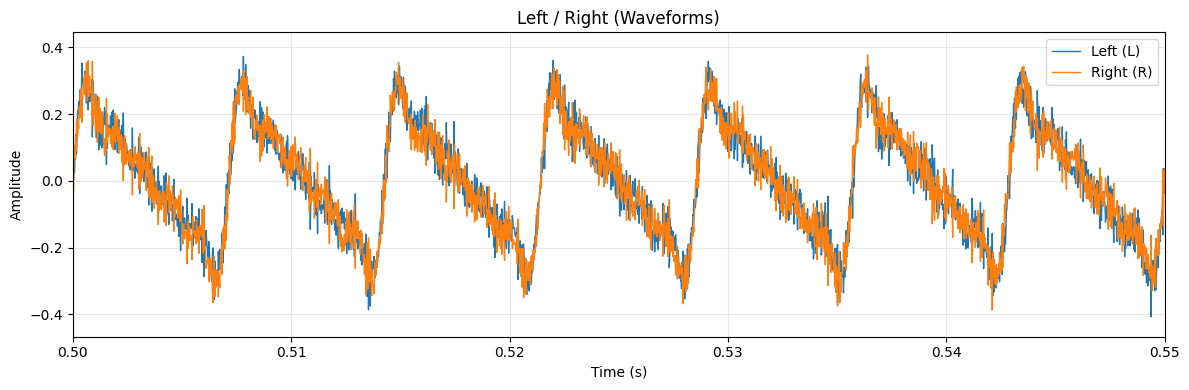

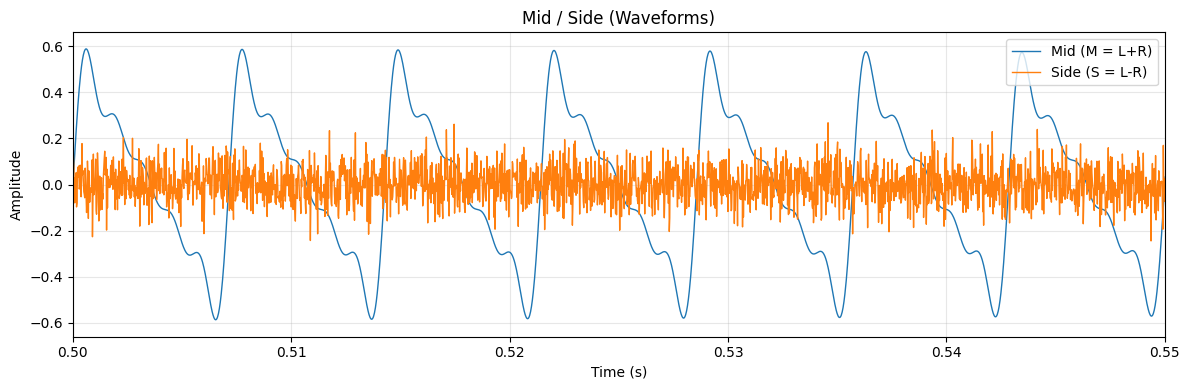

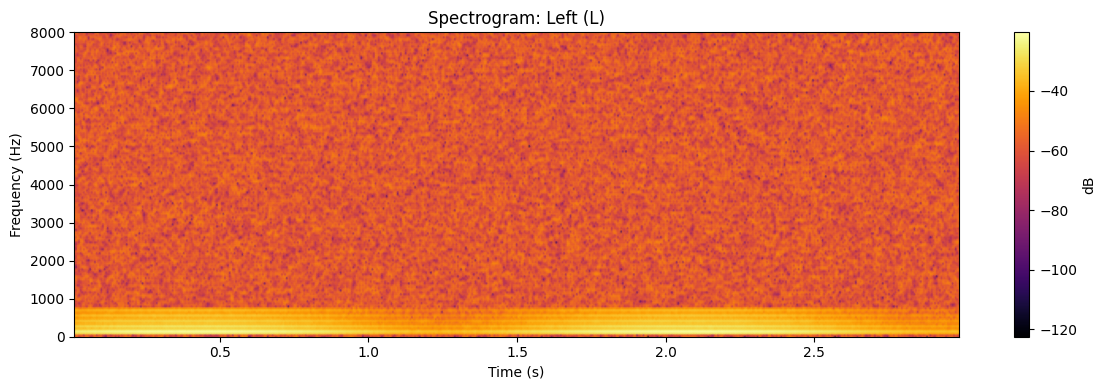

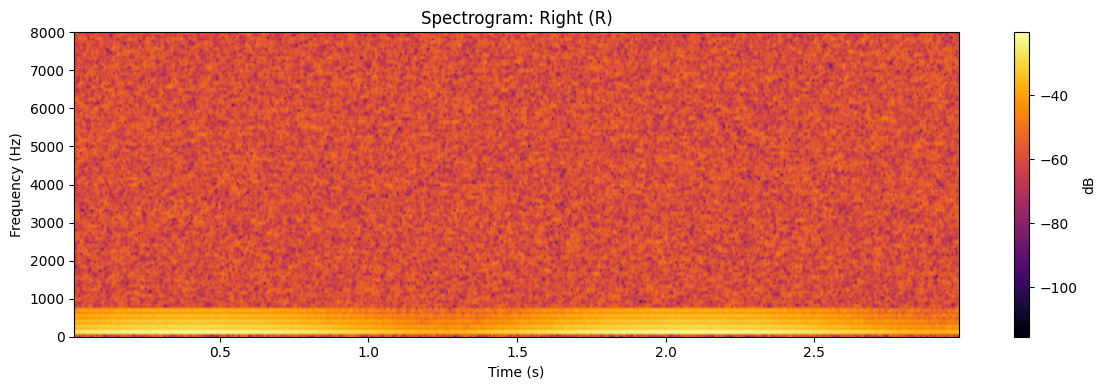

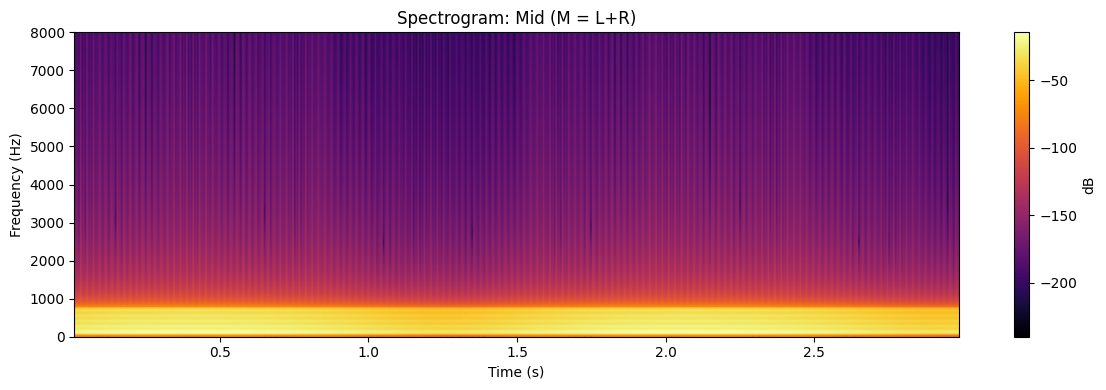

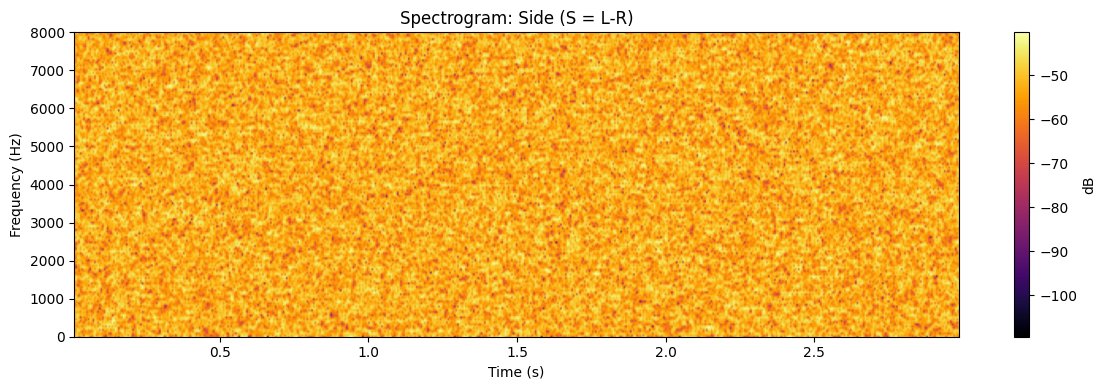

Reconstruction RMS error: 0.00000000000000000401
  L: 4.008874475983694e-18
  R: 4.070618129820268e-18


L/R stereo (original):


M/S split-monitoring (Left = Mid, Right = Side):


Mid only (phantom center):


Side only (width / anti-phase):


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import Audio, display

# ----------------------------
# 1) Utilities: M/S math + plotting helpers
# ----------------------------

def lr_to_ms(L, R):
    """
    Classic M/S:
      M = L + R
      S = L - R
    """
    M = L + R
    S = L - R
    return M, S

def ms_to_lr(M, S):
    """
    Inverse:
      L = (M + S)/2
      R = (M - S)/2
    """
    L = 0.5 * (M + S)
    R = 0.5 * (M - S)
    return L, R

def rms(x):
    return np.sqrt(np.mean(np.square(x)))

def normalize_peak(x, peak=0.95):
    m = np.max(np.abs(x)) + 1e-12
    return x * (peak / m)

def plot_waveforms(t, signals, title, tlim=None):
    """
    signals: list of (label, x)
    """
    plt.figure(figsize=(12, 4))
    for label, x in signals:
        plt.plot(t, x, label=label, linewidth=1)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    if tlim is not None:
        plt.xlim(*tlim)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper right")
    plt.tight_layout()

def stereo(xL, xR):
    """IPython Audio expects shape (n_channels, n_samples)."""
    return np.vstack([np.asarray(xL), np.asarray(xR)])

def audio_safe(x, fs, peak=0.98):
    """
    Robust IPython playback on Windows:
    - float32
    - replace NaN/Inf
    - peak-normalize
    - clip to [-1, 1]
    - disable IPython normalize (we already normalized)
    """
    x = np.asarray(x, dtype=np.float32)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

    mx = float(np.max(np.abs(x))) + 1e-12
    g = min(1.0, peak / mx)
    x = x * g

    x = np.clip(x, -1.0, 1.0)
    return Audio(x, rate=fs, normalize=False)


def plot_spectrogram(fs, x, title, nperseg=1024, noverlap=768):
    """
    STFT-based spectrogram (magnitude in dB).
    """
    f, tt, Z = signal.stft(x, fs=fs, window="hann", nperseg=nperseg, noverlap=noverlap, padded=False, boundary=None)
    mag = np.abs(Z)
    mag_db = 20*np.log10(np.maximum(mag, 1e-12))

    plt.figure(figsize=(12, 4))
    # plt.pcolormesh(tt, f, mag_db, shading="auto")
    plt.pcolormesh(tt, f, mag_db, shading="gouraud", cmap="inferno")
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, min(8000, fs/2))
    cbar = plt.colorbar()
    cbar.set_label("dB")
    plt.tight_layout()

# ----------------------------
# 2) Create a synthetic stereo example with obvious Mid vs Side structure
# ----------------------------

fs = 48000
dur = 3.0
t = np.arange(int(fs * dur)) / fs

# "Voice-like" mid component: harmonic stack with slow AM (centered)
f0 = 140.0
harmonics = [1, 2, 3, 4, 5]
amps =      [1.0, 0.5, 0.35, 0.25, 0.18]
mid_tone = sum(a * np.sin(2*np.pi*(k*f0)*t) for k, a in zip(harmonics, amps))
mid_env = 0.6 + 0.4*np.sin(2*np.pi*0.6*t)   # gentle level motion
M_true = mid_tone * mid_env

# Side component: "widthy" stuff (decorrelated-ish): filtered noise + slight delay difference
rng = np.random.default_rng(0)
noise = rng.standard_normal(len(t))

# Add a short comb-ish texture (a tiny delay feedback)
delay_samp = int(0.012 * fs)  # 12 ms
g = 0.5
S_true = noise.copy()
S_true[delay_samp:] += g * noise[:-delay_samp]

# Normalize components
M_true = normalize_peak(M_true, 0.6)
S_true = normalize_peak(S_true, 0.35)

# Build L/R from M/S to guarantee "clean" meaning:
L, R = ms_to_lr(M_true, S_true)

# Optional: scale to prevent clipping
LR_peak = max(np.max(np.abs(L)), np.max(np.abs(R))) + 1e-12
if LR_peak > 0.98:
    L = L / LR_peak * 0.98
    R = R / LR_peak * 0.98

# ----------------------------
# 3) Demonstrate M/S transform + perfect reconstruction
# ----------------------------

M, S = lr_to_ms(L, R)
L_rec, R_rec = ms_to_lr(M, S)

err_L = rms(L - L_rec)
err_R = rms(R - R_rec)

# ----------------------------
# 4) Waveform visualization: L/R vs M/S
# ----------------------------

# Show a zoom where you can *see* phasey differences
tlim = (0.5, 0.55)

plot_waveforms(
    t,
    [("Left (L)", L), ("Right (R)", R)],
    "Left / Right (Waveforms)",
    tlim=tlim
)

plot_waveforms(
    t,
    [("Mid (M = L+R)", M), ("Side (S = L-R)", S)],
    "Mid / Side (Waveforms)",
    tlim=tlim
)

# ----------------------------
# 5) Spectrograms: L, R, M, S
# ----------------------------

plot_spectrogram(fs, L, "Spectrogram: Left (L)")
plot_spectrogram(fs, R, "Spectrogram: Right (R)")
plot_spectrogram(fs, M, "Spectrogram: Mid (M = L+R)")
plot_spectrogram(fs, S, "Spectrogram: Side (S = L-R)")

plt.show()

print("Reconstruction RMS error: " + "{:.20f}".format(err_L))
print("  L:", err_L)
print("  R:", err_R)

print("\n")

print("L/R stereo (original):")
display(audio_safe(stereo(L, R), fs))

print("M/S split-monitoring (Left = Mid, Right = Side):")
display(audio_safe(stereo(M, S), fs))

print("Mid only (phantom center):")
display(audio_safe(stereo(0.5*M, 0.5*M), fs))

print("Side only (width / anti-phase):")
display(audio_safe(stereo(0.5*S, -0.5*S), fs))


- Nothing is lost. Nothing is destroyed.
- You're just rotating the coordinate system.
- The tiny error you see is just floating-point rounding.
#
- This technique is widely used in audio processing and audio compression algorithms to decorrelate channels, improve coding efficiency, and enable independent control of mono and stereo components.

## **Normalization and SNR**
- Normalization is simply the process of adjusting the overall level of an audio signal so it sits at a chosen reference value - usually peak level (there's also loudness normalization, but that goes deeper into audio engineering, specifically mastering).
- You take different audio samples and apply one gain value so they all land on the same target.
- It can be non-destructive - but if you don't remember the original levels, you've lost the dynamic differences between signals.
- Normalization forgets history.
# 
- Normalization sets a single gain (level) value to the entire signal.
- Peak normalization only cares about the loudest sample (often a single value out of thousands), not how loud the signal is on average.
- It listens to one spike and ignores everything else. The overall shape is there - but the dynamic context is forgotten.
#
- Keep in mind that in real audio, lower-level signals usually contain proportionally more noise (they have a lower SNR). So when you normalize them, you’re turning the noise up as well.
- **SNR** (Signal-to-Noise Ratio) is signal divided by noise - how much useful information you have compared to unwanted noise.
- High SNR → signal is much louder than noise → clean audio
- Low SNR → noise is close to the signal → hiss, grain, mud
# 
- SNR describes data quality.
- Normalization cannot improve SNR, it can only reveal how bad it already was. Normalization scales signal and noise together - SNR stays exactly the same.
- With low SNR, the largest peak can easily come from the noise, not the signal - so peak normalization may end up 'locking onto' a noise spike.

Sidenote: loudness normalization uses average energy instead (traditionally RMS - root mean square), and the modern standard is LUFS (Loudness Units relative to Full Scale), which adds perceptual weighting and gating to better reflect how we hear loudness (inspired by our hearing at ~70–80 phon).

Here are 3 signals with different levels but identical noise, the red dot indicates the global peak sample:


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Audio

# ----------------------------
# Helpers
# ----------------------------
def db_to_lin(db):
    return 10**(db/20)

def rms(x):
    return np.sqrt(np.mean(x**2))

def peak_norm(x, target_db=0.0):
    """Peak-normalize to target_db (dBFS). Returns (y, gain)."""
    p = np.max(np.abs(x))  # GLOBAL peak over full signal
    g = db_to_lin(target_db) / (p + 1e-12)
    return x * g, g

def snr_db(signal, noise):
    return 20*np.log10(rms(signal) / (rms(noise) + 1e-12))

def shift_samples(x, ms, fs):
    """Circular shift by ms (positive = later)."""
    n = int(round(ms * fs / 1000.0))
    return np.roll(x, n)

# ----------------------------
# Build base signal + shared noise
# ----------------------------
fs = 48000
t = np.arange(int(fs*2.0))/fs

pure = np.sin(2*np.pi*220*t)

rng = np.random.default_rng(0)
noise = 0.02 * rng.standard_normal(len(t))

# Loud → quiet
levels = [-6, -15, -30]

# Put peaks at different places within the same 50 ms window:
# 2nd first, then 1st, then 3rd near the end.
peak_offsets_ms = {
    -15: -12.0,  # earlier
    -6:   0.0,   # middle
    -30: +16.0,  # later
}

signals = []
for db in levels:
    s = pure * db_to_lin(db)
    s = shift_samples(s, peak_offsets_ms[db], fs)   # <-- shift the SIGNAL, not the noise
    signals.append(s + noise)

# ----------------------------
# Shared zoom window (same for all subplots)
# ----------------------------
ZOOM_MS = 50.0
n_zoom = int(fs * (ZOOM_MS / 1000.0))

def window_around_index(idx_center, n_win, n_total):
    half = n_win // 2
    i0 = max(0, idx_center - half)
    i1 = min(n_total, i0 + n_win)
    i0 = max(0, i1 - n_win)  # keep exact length near ends
    return i0, i1

def local_peak_in_window(x, i0, i1):
    """Peak index inside [i0:i1)."""
    k = int(np.argmax(np.abs(x[i0:i1])))
    return i0 + k

# ----------------------------
# UI helpers
# ----------------------------
def set_toggle_color(btn):
    if btn.value:
        btn.style.button_color = "#2ecc71"
        btn.description = "Normalize: ON"
    else:
        btn.style.button_color = "#e74c3c"
        btn.description = "Normalize: OFF"

# ----------------------------
# Plot
# ----------------------------
def draw(normalize, target_db):

    target_db = float(target_db)

    mixes = []
    gains = []

    for x in signals:
        if normalize:
            y, g = peak_norm(x, target_db)
            mixes.append(y)
            gains.append(g)
        else:
            mixes.append(x)
            gains.append(1.0)

    # ONE shared 50 ms window for all plots.
    # Anchor the window around the global peak of the FIRST mix (−6 dB)
    idx_ref = int(np.argmax(np.abs(mixes[0])))
    i0, i1 = window_around_index(idx_ref, n_zoom, len(t))

    # Shared time axis in ms, centered at idx_ref (0 ms = reference peak position)
    tz = (t[i0:i1] - t[idx_ref]) * 1000.0

    fig, axes = plt.subplots(len(levels), 1, figsize=(12, 7), sharex=True)

    for ax, mix, g, db in zip(axes, mixes, gains, levels):
        # Find the peak INSIDE the shared window (so it can appear at different ms positions)
        idx_peak = local_peak_in_window(mix, i0, i1)
        peak_ms = (t[idx_peak] - t[idx_ref]) * 1000.0

        ax.plot(tz, mix[i0:i1], lw=1.5, label="signal + noise")
        ax.scatter(peak_ms, mix[idx_peak], color="red", s=40, zorder=5)

        # plot noise with the same gain when normalized
        nplot = (noise * g) if normalize else noise
        ax.plot(tz, nplot[i0:i1], label="noise", alpha=0.8)

        ax.set_title(
            f"{db} dBFS"
            + (f" → normalized to {target_db:g} dBFS" if normalize else "")
        )

        ax.set_ylim(-1, 1)
        ax.set_ylabel("Amp")
        ax.grid(alpha=.3)
        ax.legend(loc="upper right")

    axes[-1].set_xlabel("Time in shared 50 ms window (ms)")
    plt.tight_layout()
    plt.show()

    print("SNR per signal:")
    for db in levels:
        s = pure * db_to_lin(db)
        s = shift_samples(s, peak_offsets_ms[db], fs)  # keep SNR calc consistent with what we plotted

        if normalize:
            # use the gain computed from the MIX (signal+noise), just like peak normalization does
            _, g = peak_norm(s + noise, target_db)
            s_eff = s * g
            n_eff = noise * g
        else:
            s_eff = s
            n_eff = noise

        print(f"{db:>4} dBFS → {snr_db(s_eff, n_eff):6.1f} dB")

    if normalize:
        print("\nNormalization ON → signal and noise both rise together (SNR stays the same).")
    else:
        print("\nNormalization OFF → quieter signals have worse SNR (noise is fixed).")

# ----------------------------
# Widgets
# ----------------------------
normalize_btn = widgets.ToggleButton(value=False)
targets = [0, -1, -3, -6, -12]
target_dd = widgets.Dropdown(
    options=[(f"{v:g} dBFS", float(v)) for v in targets],
    value=0.0,
    description="Target:"
)

set_toggle_color(normalize_btn)

normalize_btn.observe(lambda c: set_toggle_color(normalize_btn), names="value")
normalize_btn.observe(lambda c: setattr(target_dd, "disabled", not normalize_btn.value), names="value")
target_dd.disabled = True

display(widgets.HBox([normalize_btn, target_dd]))
display(widgets.interactive_output(draw, {"normalize": normalize_btn, "target_db": target_dd}))

# ----------------------------
# 3 separate audio players (auto-updating, current mode)
# ----------------------------
audio_out = widgets.Output()

def render_audios(*_):
    audio_out.clear_output(wait=True)

    with audio_out:
        for db, x in zip(levels, signals):
            if normalize_btn.value:
                y, _ = peak_norm(x, float(target_dd.value))
                suffix = f" → {float(target_dd.value):g} dBFS (peak)"
            else:
                y = x
                suffix = ""

            y = np.clip(y, -1.0, 1.0).astype(np.float32)

            print(f"{db} dBFS{suffix}")
            display(Audio(y, rate=fs, normalize=False))

normalize_btn.observe(render_audios, names="value")
target_dd.observe(render_audios, names="value")

render_audios()
display(audio_out)

Output()

Output()

**dBTP or True Peak**
- Samples at 0 dBFS (or below) do not guarantee the signal won't clip at the output.
- Digital samples are only points. The reconstructed waveform between those points can exceed them (because it reconstructs continuous waveform, not a flat line).
# 
- dBFS (sample peak): max of discrete samples.
- dBTP (true peak): max of the continuous-time waveform estimate which can be higher.
# 
- Sample peaks describe data.
- True peaks describe reality.
#
- This reconstruction is estimated by oversampling and applying a low-pass (high-cut) filter at Nyquist, approximating how DACs (digital-to-analog conversion) work.
- Real audio devices usually operate internally at much higher sample rates (oversampling).
#
Sidenote: lossy audio compression (MP3, AAC, Opus, etc.) can make this even worse, because they change the waveform and can introduce additional intersample peaks.
#
Here's an example:
- Dots: discrete samples
- Curve: reconstructed waveform

Sample peak: -0.000000 dBFS
True peak:   +5.217267 dBTP


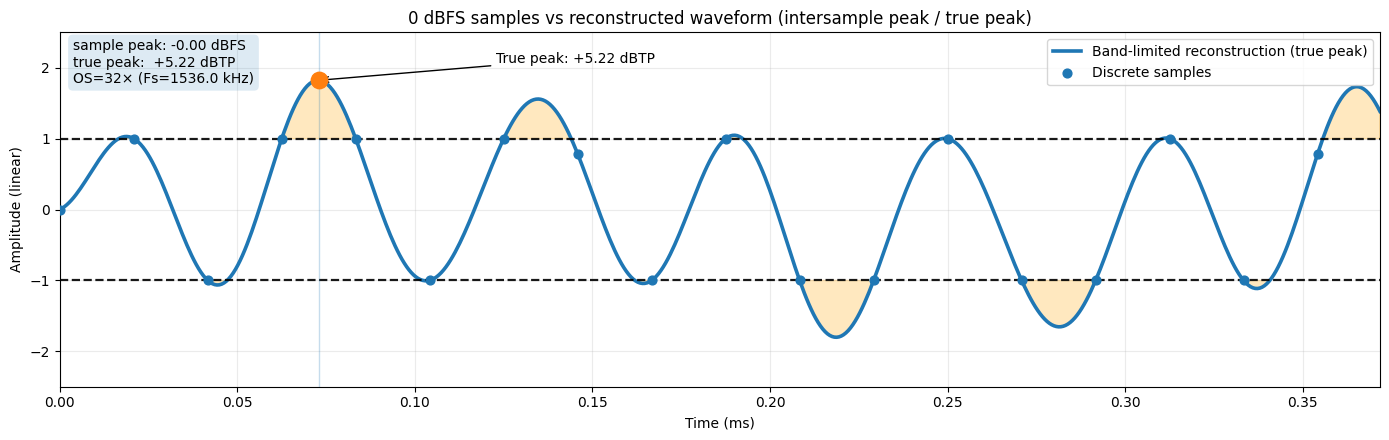

In [16]:
import numpy as np
import matplotlib.pyplot as plt

fs = 48_000
OS = 32
N = 4096

f = 17_000.0
n = np.arange(N)
x = np.sin(2 * np.pi * f * n / fs)
x = np.clip(6.0 * x, -1.0, 1.0)
x = x / (np.max(np.abs(x)) + 1e-12)

def oversample_fft(x, os):
    X = np.fft.rfft(x)
    m = len(x) * os
    Y = np.zeros(m // 2 + 1, dtype=np.complex128)
    Y[:len(X)] = X
    return np.fft.irfft(Y, n=m) * os

def db(val):
    return 20 * np.log10(val + 1e-12)

y = oversample_fft(x, OS)

sp = np.max(np.abs(x))
tp = np.max(np.abs(y))
sp_dbfs = db(sp)          # ~0 dBFS
tp_dbtp = db(tp)          # can be >0 dBTP

print(f"Sample peak: {sp_dbfs:.6f} dBFS")
print(f"True peak:   {tp_dbtp:+.6f} dBTP")

idx_tp = int(np.argmax(np.abs(y)))
t_os = np.arange(len(y)) / (fs * OS)

half_ms = 0.30
half = int((half_ms / 1000.0) * fs * OS)
i0 = max(0, idx_tp - half)
i1 = min(len(y), idx_tp + half)

t0 = t_os[i0]
tz = (t_os[i0:i1] - t0) * 1000.0
y_zoom = y[i0:i1]

sidx = np.arange(len(x)) * OS
mask = (sidx >= i0) & (sidx < i1)
tz_s = (t_os[sidx[mask]] - t0) * 1000.0
x_s = x[mask]

k = int(np.argmax(np.abs(y_zoom)))
t_peak = tz[k]
y_peak = y_zoom[k]

plt.figure(figsize=(14, 4.5))

plt.plot(tz, y_zoom, lw=2.6, label="Band-limited reconstruction (true peak)")
plt.scatter(tz_s, x_s, s=40, zorder=5, label="Discrete samples")

# Digital full-scale bounds
plt.axhline(1.0, color="black", lw=1.6, linestyle="--", alpha=0.9)
plt.axhline(-1.0, color="black", lw=1.6, linestyle="--", alpha=0.9)

# Mark where the true peak happens
plt.axvline(t_peak, lw=1, alpha=0.25)

# Shade overs: where reconstruction exceeds digital ceiling
mask = np.abs(y_zoom) > 1.0
plt.fill_between(
    tz,
    np.clip(y_zoom, -1, 1),
    y_zoom,
    where=mask,
    color="orange",
    alpha=0.25
)

# Annotate the true peak in dBTP (this is the whole point)
plt.scatter([t_peak], [y_peak], s=140, zorder=6)
plt.annotate(
    f"True peak: {tp_dbtp:+.2f} dBTP",
    xy=(t_peak, y_peak),
    xytext=(t_peak + 0.05, y_peak + 0.25 * np.sign(y_peak)),
    arrowprops=dict(arrowstyle="->", lw=1),
)

# Small info box (teaching-friendly)
plt.text(
    0.01, 0.98,
    f"sample peak: {sp_dbfs:+.2f} dBFS\ntrue peak:  {tp_dbtp:+.2f} dBTP\nOS={OS}× (Fs={fs*OS/1000:.1f} kHz)",
    transform=plt.gca().transAxes,
    va="top", ha="left",
    bbox=dict(boxstyle="round,pad=0.35", alpha=0.15, edgecolor="none")
)

plt.title("0 dBFS samples vs reconstructed waveform (intersample peak / true peak)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (linear)")
plt.ylim(-2.5, 2.5)
plt.xlim(0, tz[-1])
plt.grid(alpha=0.25)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

As a summary:
- **Sound is energy in motion.**
- **Processing reshapes that energy.**
- **Reshaping always costs something.**
#
Get ready to destroy it.
#
*[Everything is made of atoms…](https://www.feynmanlectures.caltech.edu/I_01.html)*
#
Thank you.
#
P.S. What sounds nicer than a Christmas carol?
https://www.youtube.com/watch?v=oY6OenvCDqw